In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read data
dt=pd.read_csv("diabetic_data.csv")

In [3]:
# Categorical and Continuous data
print("There are ", len(dt.select_dtypes(include=['object']).columns), "object variables")
print("There are ", len(dt.select_dtypes(include=['int64']).columns), "continuous columns")

There are  37 object variables
There are  13 continuous columns


In [4]:
# Check missing values
dt.isnull().values.any()

False

In [6]:
# Check missing values through count
# Same information as above no missing values
dt.describe().columns[dt.describe().loc['count'] != dt.shape[0]]

Index([], dtype='object')

In [8]:
# Checking Duplicates
# dt[dt.duplicated()].count()
dt.duplicated().values.any()

False

In [9]:
# Look at data
dt.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
# Replace '?' with NANs
dt.replace("?", np.nan, inplace=True)

In [11]:
# Check missing values
dt.isnull().values.any()

True

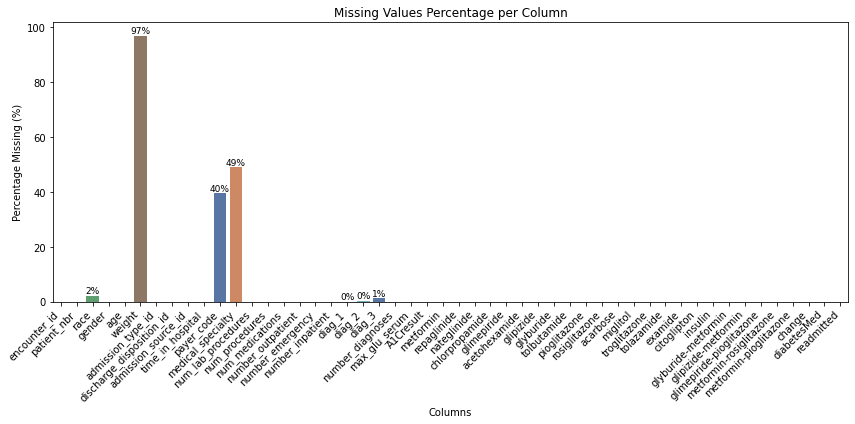

In [12]:
# checkin percentage of missing attribute per column
# Assuming 'df' is your DataFrame
missing_data = dt.isnull().mean() * 100  # Calculate the percentage of missing values per column

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_data.index, y=missing_data.values, palette='deep')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate the bars with percentage values (if greater than 0)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',fontsize=9)
plt.show()

In [ ]:
# Remove ID variables, Weight
dt=dt.drop(["patient_nbr","encounter_id","weight"],axis=1)

# ---> We need to look how to impute missing data from race, , payer code, medical specialty, Diag[1,2,3]

+ Looking into the Medical_specialy 

## Looking at graphs to see if we can find relationships between the missing variables 

+ Checking correlation plot to see if we can use a variable that is correlated with our target variable to check those with the missing columns

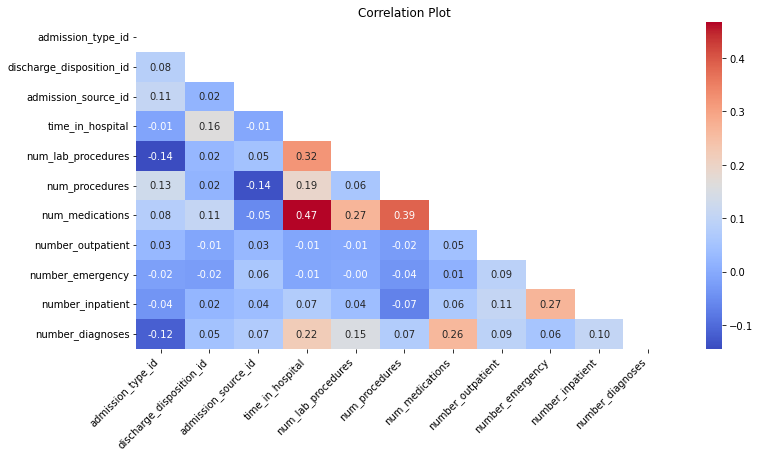

In [51]:
corr_matrix = dt.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 6))  

# Create the correlation plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Plot')
plt.show()

In [16]:
readmit = pd.crosstab(dt['medical_specialty'], dt['readmitted'])

# Calculate the percentage based on the sum of counts within each race group
readmit_percentage = readmit.div(readmit.sum(1), axis=0) * 100

readmit_percentage.sort_values(by='NO', ascending=False).head(5)

readmitted,<30,>30,NO
medical_specialty,,,
Psychiatry-Addictive,0.0,0.0,100.0
Speech,0.0,0.0,100.0
Neurophysiology,0.0,0.0,100.0
Perinatology,0.0,0.0,100.0
Proctology,0.0,0.0,100.0


In [17]:
# Looking at num Medications and Readmitted relation with "medical specialty"
# info on the missing data on Medical Specialty in relation to readmitted and number of diagnoses
# the mean is 15
dt[dt['medical_specialty'].isnull()][["readmitted","num_medications"]].describe()

,num_medications
count,49949.000000
mean,16.326573
std,7.951627
min,1.000000
25%,11.000000
50%,15.000000
75%,20.000000
max,72.000000


In [26]:
# Lets create a crosstab and find those that have a median of 15
p=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["num_medications"], aggfunc='median')
# Filter those columns were at least one category equal to 15
p[(p == 15).any(axis=1)]


readmitted,<30,>30,NO
medical_specialty,,,
Cardiology,16.0,15.0,15.0
Family/GeneralPractice,15.0,14.0,12.0
Hospitalist,17.0,15.0,16.0
InternalMedicine,15.0,14.0,13.0
Oncology,14.0,16.0,15.0
Otolaryngology,12.0,19.0,15.0
Pediatrics-Pulmonology,12.0,15.0,14.0
Podiatry,22.5,16.0,15.0
Pulmonology,18.0,15.0,13.0


+ An option for the missing variables in medical_specialty would be
    - Yes "<30"=Could be(Family/GeneralPractice or InternalMedicine Surgeon)
    - Yes ">30"= Cardiology, Hospitalist, Pediatris-Pulmonology, Pulmonology or Surgery-PlasticWithinHeadandNeck
    - NO= Cardiology, Oncology, Otolaryngology, Podiatry, Surgeon or Surgery_general
+ However, we are aware there may not be a relationship 100% however better than guessing

In [75]:
#Diagnoses would have a relation with Medical specialty so looking into that relationship
#info on the missing data in relation to readmitted and number of diagnoses
dt[dt['medical_specialty'].isnull()][["readmitted","number_diagnoses"]].describe()

,number_diagnoses
count,49949.000000
mean,7.748764
std,1.785262
min,1.000000
25%,7.000000
50%,9.000000
75%,9.000000
max,16.000000


In [90]:
p=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["number_diagnoses"], aggfunc='median')
# Too many options and no pattern was found
len(p[(p == 9).any(axis=1)])

# p.sort_values(by='NO', ascending=False).head(10)

29

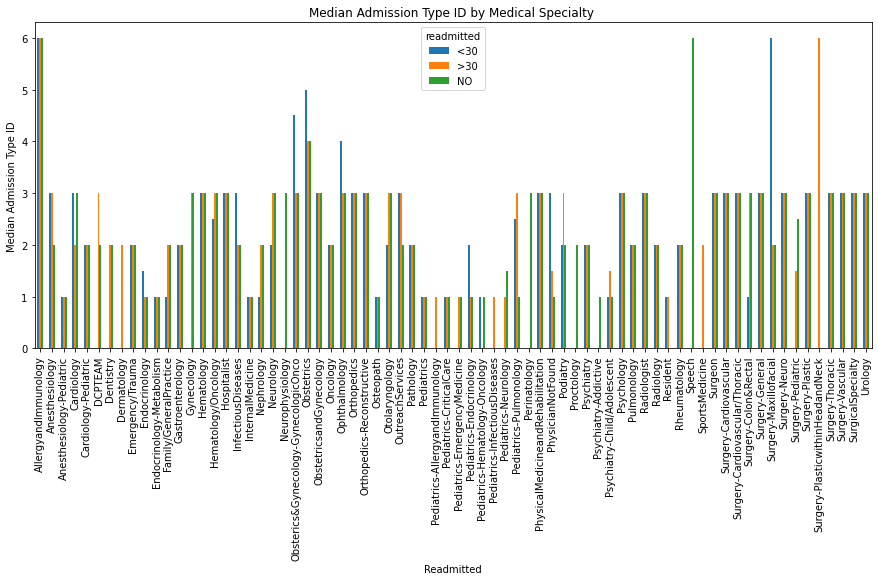

In [34]:
# Plot the transposed DataFrame
p.plot(kind='bar', figsize=(15, 6))  # You can adjust the figure size as needed

# Add labels and title
plt.xlabel('Readmitted')
plt.ylabel('num_medications')
plt.title('Median num_medications by Medical Specialty ')

plt.show()

l=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["admission_type_id"], aggfunc='median')

# Plot the transposed DataFrame
l.plot(kind='bar', figsize=(15, 6))  # You can adjust the figure size as needed

# Add labels and title
plt.xlabel('Readmitted')
plt.ylabel('Median Admission Type ID')
plt.title('Median Admission Type ID by Medical Specialty ')

plt.show()

**Relationships found per Corr plot**
+ Num of Medication and time in hospital
+ Lab procedures and time in hospital
+ Num procedures and num of medication
+ Num of diagnoses and num of medications
+ Num of diagnoses with time in hospital
+ Admission type  and num of procedures


## The variable seems to be missing at random 
# Running Random Forest to replacing missing medical_specialty values

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

# creating a list with all categorical varible excluding Medical specialty
categorical_columns=list(dt.select_dtypes(include=['object']).columns)
categorical_columns.remove("medical_specialty")

# One-hot encode categorical columns
data_encoded = pd.get_dummies(dt, columns=categorical_columns)

#saving the hot encoded features with missing medical specialty for later
unlabeled_X=data_encoded[data_encoded["medical_specialty"].isnull()].drop("medical_specialty",axis=1)
print(unlabeled_X.shape," Missing variables medical_specialty")

# Removing all the rows with Medical Specialty missing
data_encoded=data_encoded.dropna(subset=["medical_specialty"])
print(data_encoded.shape, " without Missing variables medical_specialty")

X_=data_encoded.drop("medical_specialty", axis=1)
y_=data_encoded["medical_specialty"]

X_train,X_test, Y_train, Y_test=train_test_split(X_,y_, test_size=0.2, random_state=42)
rm=RandomForestClassifier()

rm.fit(X_train, Y_train)

pr=rm.predict(X_test)

print('Accuracy:',accuracy_score(Y_test, pr))

(49949, 2394)  Missing variables medical_specialty
(51817, 2395)  without Missing variables medical_specialty


In [89]:
# Having built the model predict on the actual missing data
missing_MS=rm.predict(unlabeled_X)
missing_MS=list(missing_MS)

# Replaced nul values with predicted values from Randm forest
dt["medical_specialty"]=dt.apply(lambda row: missing_MS.pop(0) if pd.isna(row["medical_specialty"]) else row["medical_specialty"], axis=1)
dt["medical_specialty"].isnull().mean() 

0.0

In [95]:
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
race,2273
weight,98569
payer_code,40256
diag_1,21
diag_2,358
diag_3,1423


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(dt)

In [54]:
from sklearn.cluster import KMeans

# creating a list with all categorical varible excluding Medical specialty
categorical_columns=list(dt.select_dtypes(include=['object']).columns)
# One-hot encode categorical columns
data_encoded = pd.get_dummies(dt, columns=categorical_columns)

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(data_encoded)

# Access cluster assignments and cluster centers
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_


<Figure size 1080x1152 with 0 Axes>

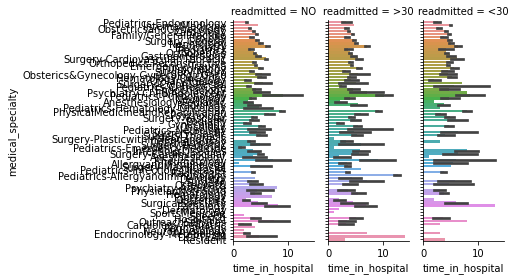

In [96]:
plt.figure(figsize=(15, 16))
sns.catplot(
    data=dt, y="medical_specialty", x="time_in_hospital", col="readmitted",
    kind="bar", height=4, aspect=.6,
)
plt.show()

In [102]:

dt[dt["race"].isna()].describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,2.273000e+03,2.273000e+03,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000
mean,1.728853e+08,4.409962e+07,1.882094,2.611967,5.031676,4.289485,44.104707,1.302684,15.813462,0.194457,0.044435,0.305763,6.695557
std,1.123099e+08,3.871054e+07,1.173805,3.618331,3.583616,2.900759,18.685559,1.794916,8.460162,0.716398,0.252202,0.735330,2.115016
min,1.485300e+05,3.643200e+04,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,9.416557e+07,1.307793e+07,1.000000,1.000000,1.000000,2.000000,33.000000,0.000000,10.000000,0.000000,0.000000,0.000000,5.000000
50%,1.107493e+08,3.823173e+07,2.000000,1.000000,6.000000,4.000000,45.000000,0.000000,14.000000,0.000000,0.000000,0.000000,7.000000
75%,2.545663e+08,6.480508e+07,2.000000,3.000000,7.000000,6.000000,57.000000,2.000000,19.000000,0.000000,0.000000,0.000000,9.000000
max,4.437285e+08,1.880406e+08,8.000000,28.000000,20.000000,14.000000,98.000000,6.000000,64.000000,11.000000,3.000000,8.000000,16.000000


In [ ]:
#K^2

# Looking at the categorical variable

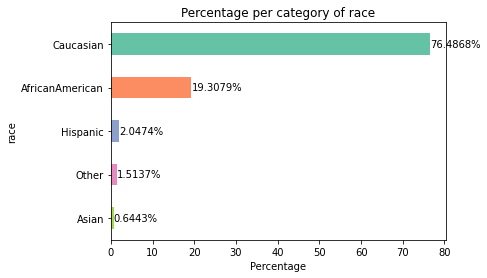

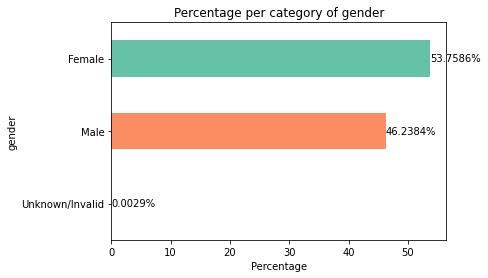

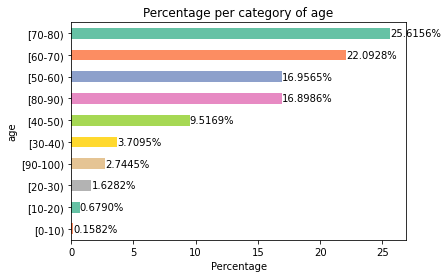

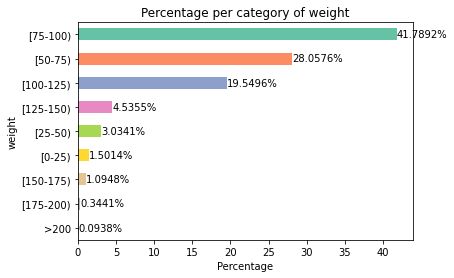

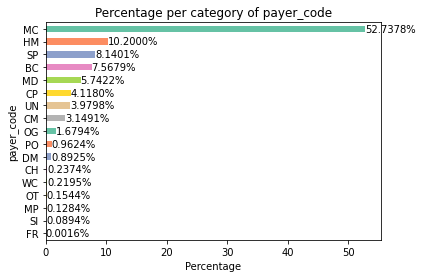

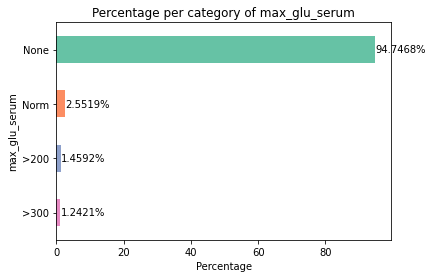

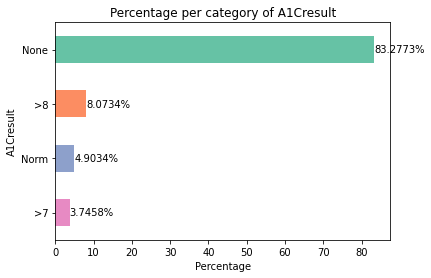

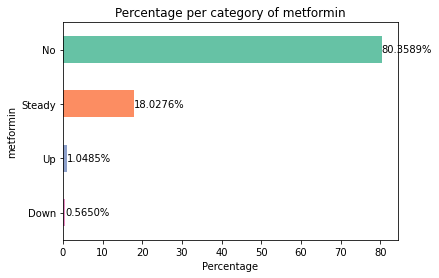

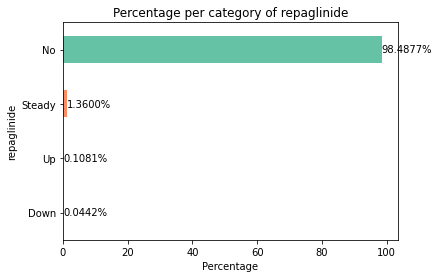

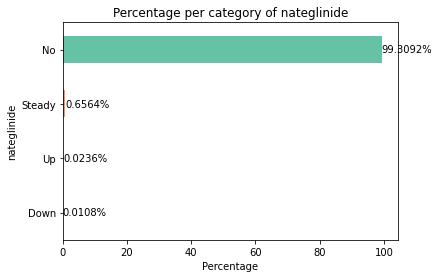

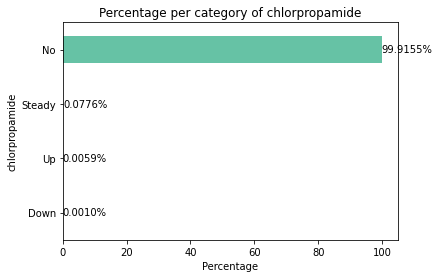

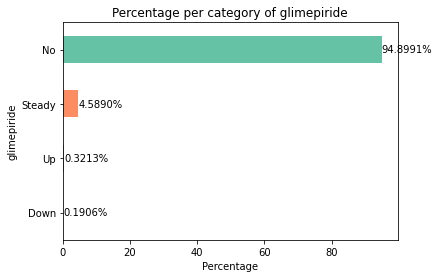

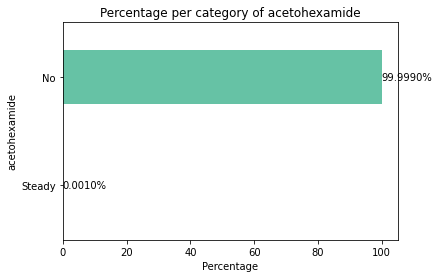

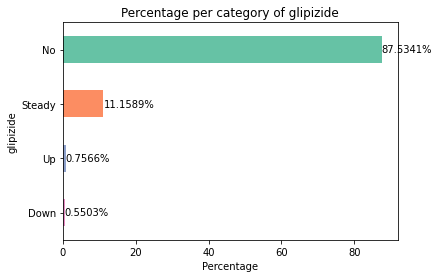

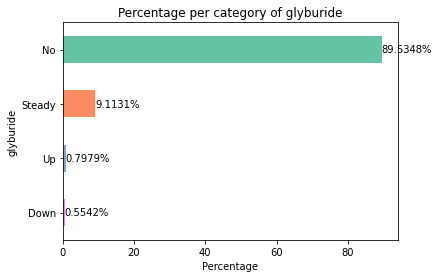

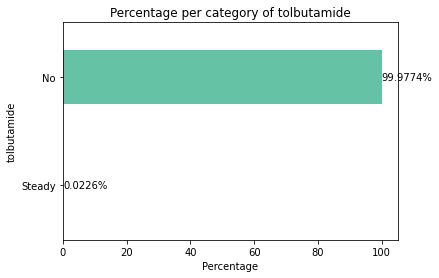

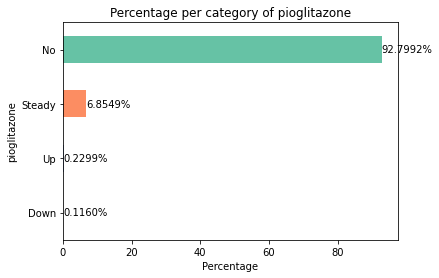

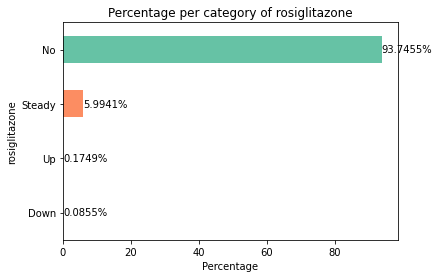

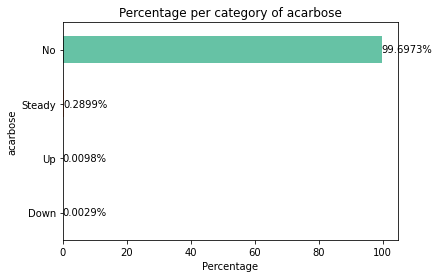

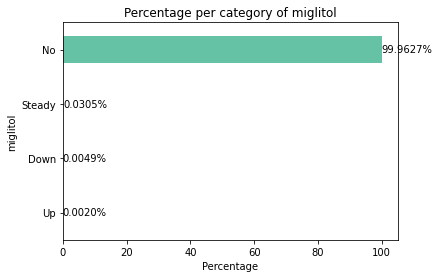

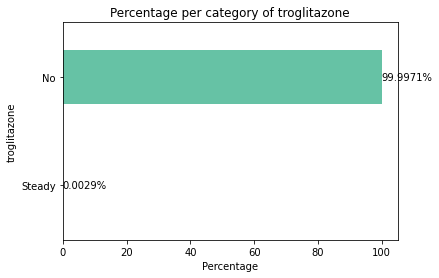

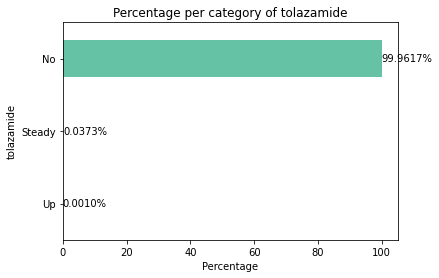

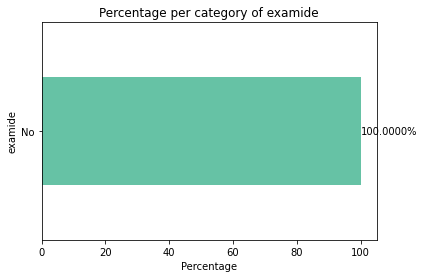

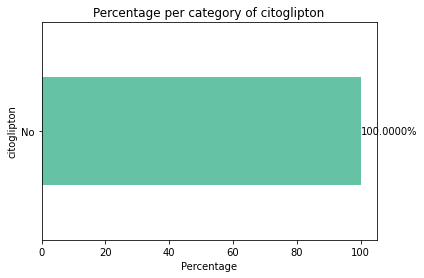

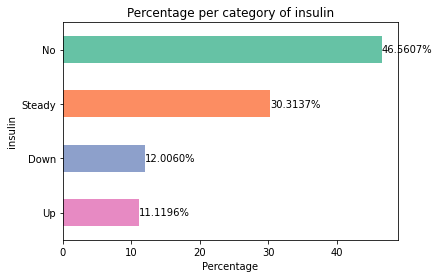

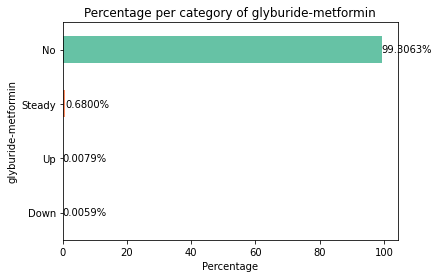

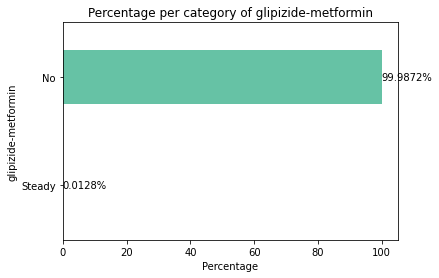

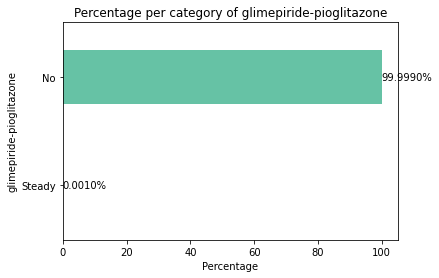

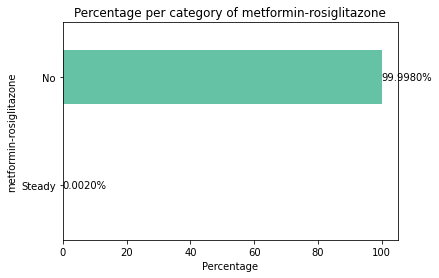

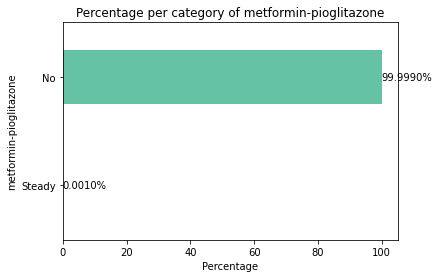

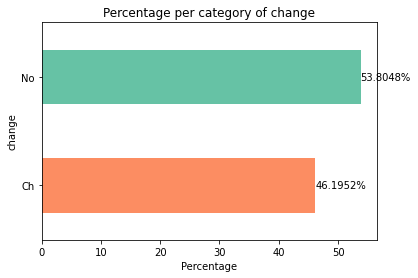

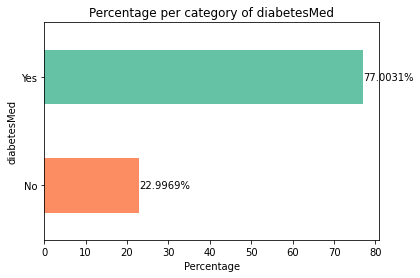

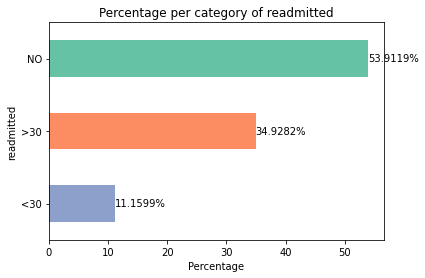

In [62]:
#Assuming 'data' is your DataFrame
cat_df = dt.select_dtypes(include=['object']).drop(["medical_specialty", "diag_1", "diag_2", "diag_3""diag_1", "diag_2", "diag_3"], axis=1)

# Get the number of unique categories for each column
num_categories = cat_df.nunique()

# Define a color palette with as many colors as there are unique categories
color_palette = sns.color_palette("Set2", n_colors=num_categories.max())

for i in cat_df.columns:
    value_counts = dt[i].value_counts(normalize=True)
    colors = color_palette[:len(value_counts)]
    
    ax = value_counts.mul(100).plot(kind="barh", color=colors)
    
    plt.xlabel("Percentage")
    plt.ylabel(i)
    plt.title(f"Percentage per category of {i}")
    plt.gca().invert_yaxis()
    
    for index, value in enumerate(value_counts.mul(100)):
        ax.text(value, index, f'{value:.4f}%', ha='left', va='center', color='black')

    plt.show()


+ 76% is Caucasian
+ Age bucket is larger and ther is a correlation the older get hospitilized more 
+ Drop citoglipton and examide since the only value is "No"

In [59]:
# Droping examide and citoglipton which only had 1 as the value
dt=dt.drop(dt[['examide','citoglipton']], axis=1)

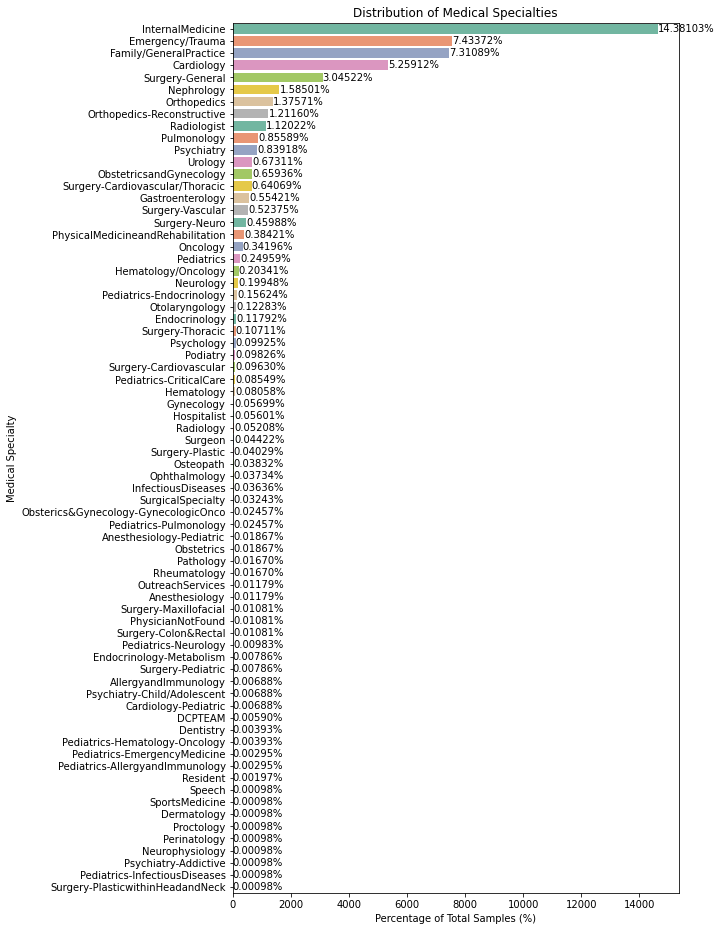

In [108]:
# Create a countplot with percentages and sorted categories
plt.figure(figsize=(8, 16))
sns.countplot(
    y=dt['medical_specialty'],
    orient='h',
    palette='Set2',
    order=dt['medical_specialty'].value_counts().index,  # Sort by count
)
plt.xlabel('Percentage of Total Samples (%)')
plt.ylabel('Medical Specialty')
plt.title('Distribution of Medical Specialties')

# Annotate the bars with percentage values
for p in plt.gca().patches:
    width = p.get_width()
    percentage = (width / len(dt)) * 100
    plt.gca().annotate(f'{percentage:.5f}%', (width + 1, p.get_y() + p.get_height() / 2), ha='left', va='center')

plt.show()


In [ ]:
# Fix "diag_1", "diag_2", "diag_3"

In [61]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

1: max diag ==1 rest 0 -->1,0,0
2: all ? to 0

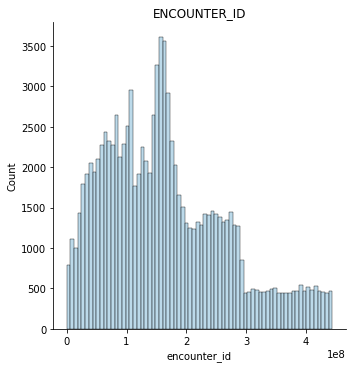

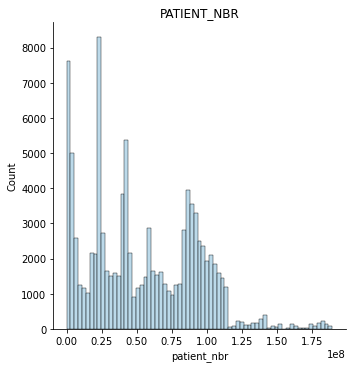

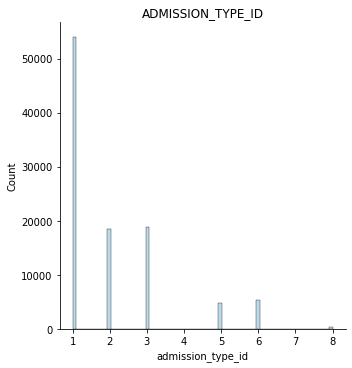

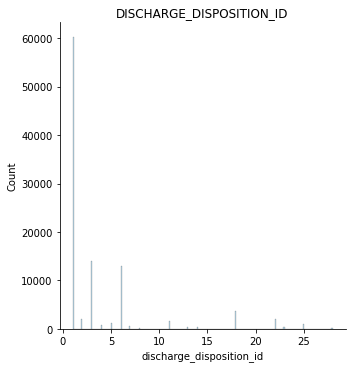

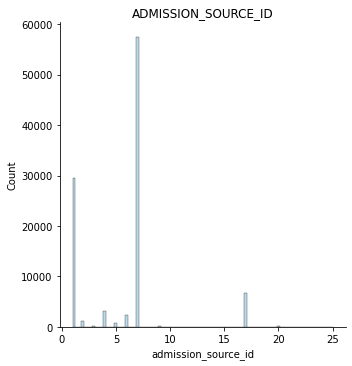

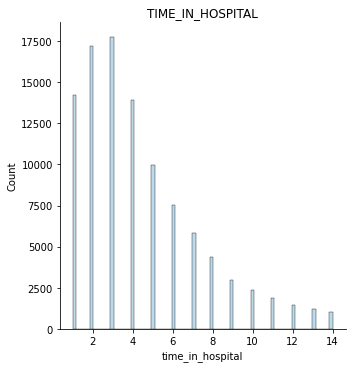

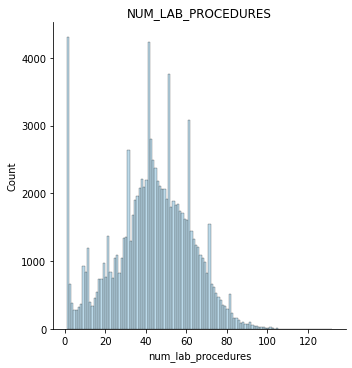

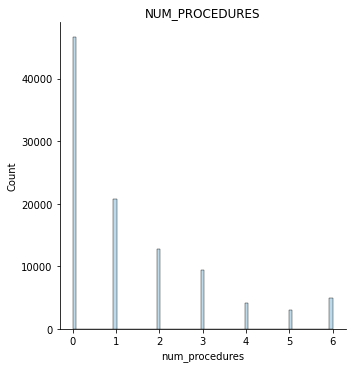

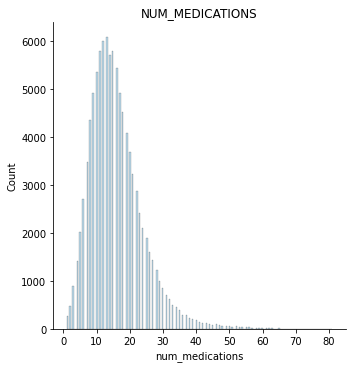

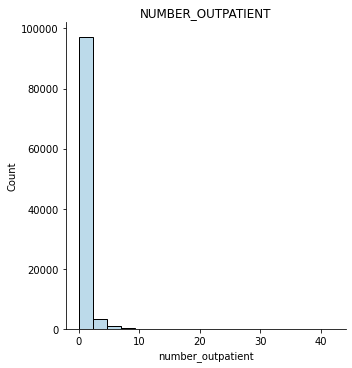

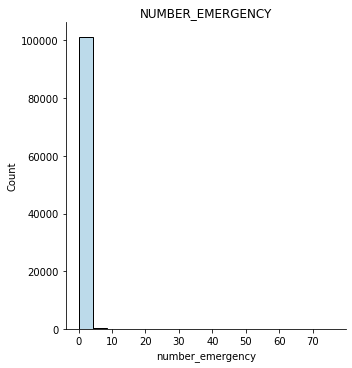

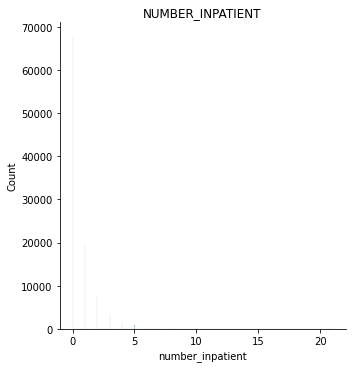

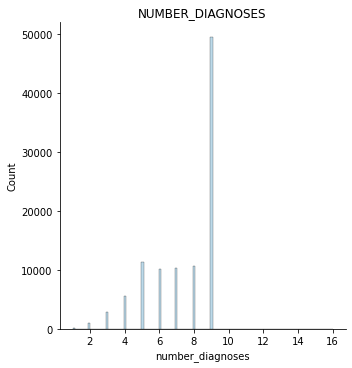

In [28]:
# Creating df of only Continuous variables
num_df = dt.f_get_numeric_data()
sns.set_palette("Paired")
for i in list(num_df):
    sns.displot(dt[i], kde=False)
    plt.title(i.upper())
    plt.show()

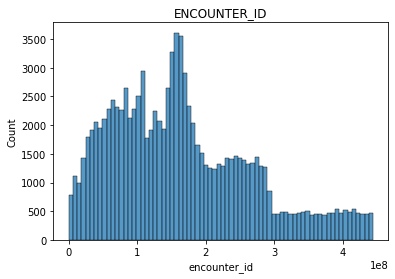

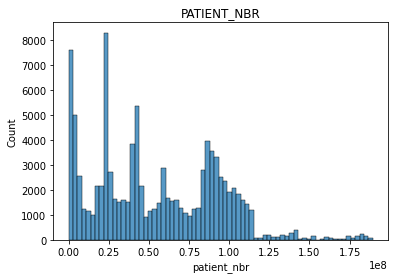

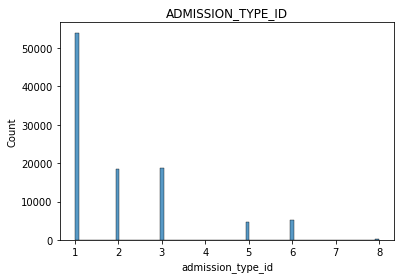

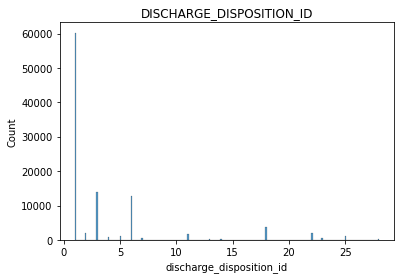

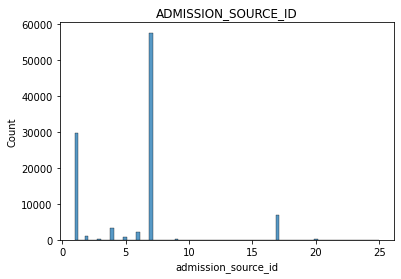

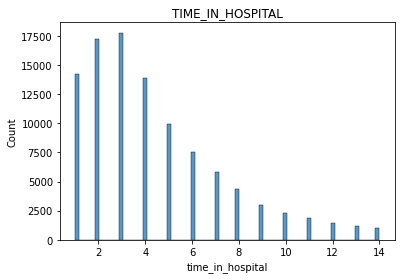

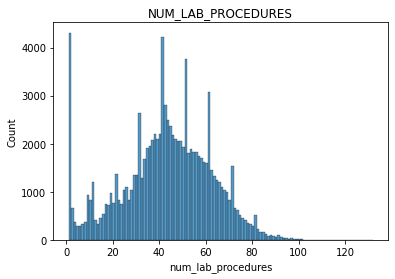

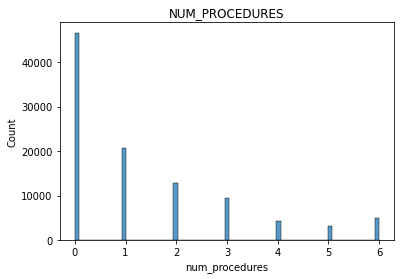

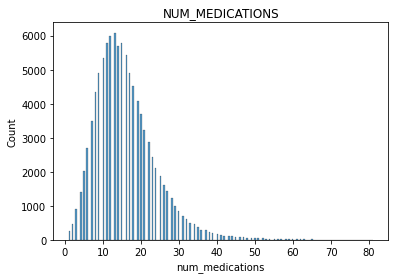

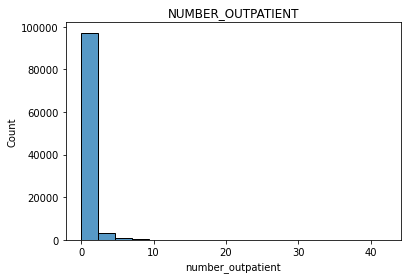

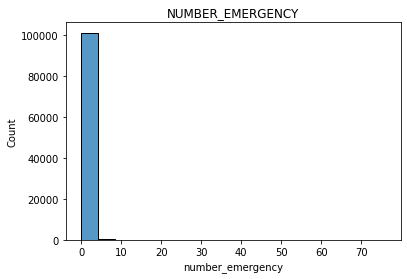

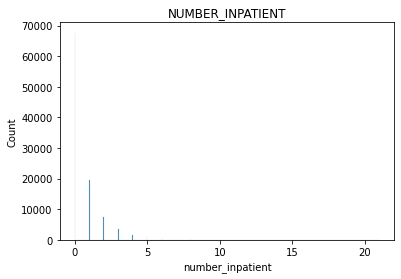

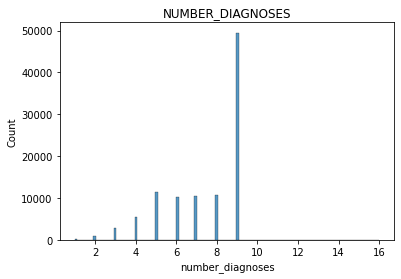

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in data.select_dtypes(include=['int64']).columns:
    sns.histplot(data[i],kde=False)
    plt.title(i.upper())
    plt.show()
#admission_type_id -> Difference between 5 Not Available, 8 Not Mapped, 6 NULL
#discharge_disposition_id -> 18 NULL, 25 Not Mapped, 26 Unknown/Invalid
#admission_source_id-->9 NOT AVAILable, 15 NOT AVAILable ,17 NULL
#<---- treat as categorical

#time in hospital
#num of procedures
#interesting num of medication is normaly distributed
#number_outpatient
#number_emergency
#number_inpatient
#num diagnoses

In [135]:
# Combining our targe to Yes and No instead of [No, >30, <30]
dup_data = dt.copy()

# Update "readmitted" column
dup_data.loc[dup_data["readmitted"] == ">30", "readmitted"] = "YES"
dup_data.loc[dup_data["readmitted"] == "<30", "readmitted"] = "YES"

# Check unique values in "readmitted" column
print(dup_data["readmitted"].unique())

['NO' 'YES']


# After inputation and EDA is complete
## ---> talk about using gender,race and age in data at the end

In [ ]:
#  --------->>>> took to long, nevere finished running
# import scipy.cluster.hierarchy as sch
# import matplotlib.pyplot as plt

# obj_col=dt.select_dtypes(include=['object']).columns.tolist()
# data_model = pd.get_dummies(dt, columns=obj_col, drop_first=True)

# # Perform hierarchical clustering
# dendrogram = sch.dendrogram(sch.linkage(data_model, method='ward'))

# # Customize the plot (optional)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Samples')
# plt.ylabel('Distance')
# plt.show()


In [55]:
#  --------->>>> Trying SelfTraining Classifier to predict missing variables
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.semi_supervised import SelfTrainingClassifier
# from sklearn.svm import SVC

# # Assuming 'dt' is your DataFrame
# a = dt.select_dtypes(include=['object']).columns.tolist()
# a.remove("medical_specialty")
# data_model = dt.dropna(subset=['medical_specialty'])

# data_model = pd.get_dummies(data_model, columns=a, drop_first=True)

# X=data_model.drop("medical_specialty",axis=1)
# y=data_model["medical_specialty"]

# # Create a base classifier (e.g., Support Vector Machine)
# base_classifier = SVC(probability=True, random_state=42)

# # Create the SelfTrainingClassifier
# self_training_classifier = SelfTrainingClassifier(
#     base_classifier, criterion='k_best', k_best=50
# )

# # Fit the SelfTrainingClassifier on the labeled data
# self_training_classifier.fit(X, y)

# self_training.predict(dt[dt['medical_specialty'].isnull()])
